In [1]:
import netgen.gui
from ngsolve import *
from netgen.geom2d import SplineGeometry
from math import pi
import matplotlib.pyplot as plt
import numpy as np

In [61]:
geo = SplineGeometry()
geo.AddRectangle((-1,-1),(1,1),bc=1)
mesh = Mesh( geo.GenerateMesh(maxh=0.5))

V = H1(mesh, order=5, dirichlet=[1])
# finite element space and gridfunction to represent the heatflux:
space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")

u = V.TrialFunction()
v = V.TestFunction()

r = sqrt(x*x+y*y)
r2 = x*x+y*y
R = 1/2

alpha = IfPos(r-R,2*log(1/R),1)

solution = IfPos(r-R,1.0/16.0*log(r2)/log(R*R),1.0/8.0-r2/4.0)
sol_flux = alpha * IfPos(r-R,1.0/16.0/log(R*R)*
                     CoefficientFunction((2*x/r2,2*y/r2)),
                     CoefficientFunction((-x/2.0,-y/2.0)))
rhs = IfPos(r-R,0,1)

RuntimeError: std::bad_cast

In [62]:
a = BilinearForm(V, symmetric=False)
a += SymbolicBFI(alpha*grad(u)*grad(v))

f = LinearForm(V)
f += SymbolicLFI(rhs*v)

gfu = GridFunction(V)
flux = alpha * grad(gfu)
#gf_flux.Set(flux)
Draw (gfu,mesh,"u")
Draw (grad(gfu),mesh,"grad_u")

In [36]:
def SolveBVP():
    V.Update()
    gfu.Update()
    
    space_flux.Update()
    gf_flux.Update()
    
    a.Assemble()
    f.Assemble()
    gfu.Set(solution)
    f.vec.data -= a.mat * gfu.vec
    gfu.vec.data += a.mat.Inverse(V.FreeDofs(),"umfpack") * f.vec
    Redraw (blocking=True)

In [37]:
def CalcError():
    space_flux.Update()
    gf_flux.Update()
    # interpolate finite element flux into H(div) space:
    gf_flux.Set (flux)
    # compute error on every element:
    err = 1/alpha*(flux - sol_flux)*(flux - sol_flux)
    elerr = Integrate (err, mesh, VOL, element_wise=True)
    
    # sort elements (corresponding to error contribution)
    err_and_el_sorted = sorted([(entry,i) for i, entry in enumerate(elerr)], key= lambda x:-x[0])
    # reset marks
    marks = [False for el in mesh.Elements()]

    # mark element with largest error until 10% of the error is on marked elements:
    sumerr = sum(elerr)    
    accsum = 0
    for err,el in err_and_el_sorted:
        if accsum < 0.1 * sumerr:
            marks[el] = True
            accsum += err
        else:
            break
    
    print ("V.ndof = ", V.ndof)
    H1error = sqrt(Integrate (1/alpha*(flux - sol_flux)*(flux - sol_flux), mesh, VOL))
    print ("weighted H1 (semi norm) error = ", H1error)
    L2error = sqrt(Integrate ((gfu - solution)*(gfu - solution), mesh, VOL))
    print ("hier L2 error = ", L2error)
    
        # call the refinement according to the marks:
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, marks[el.nr])
    return  L2error,V.ndof,sumerr

In [38]:
with TaskManager():
    L2error_2 = []
    H1error_2 = []
    d_2 = []
    #L2error_2 = []
    #d_2 = []
    while V.ndof < 10000:  
        SolveBVP()
        temp,d,H1flux = CalcError()
        L2error_2.append(temp)
        H1error_2.append(H1flux)
        d_2.append(d)
        mesh.Refine()
    SolveBVP()

V.ndof =  491
weighted H1 (semi norm) error =  0.01713316744507222
hier L2 error =  0.000744379111921183
V.ndof =  666
weighted H1 (semi norm) error =  0.013831750665250591
hier L2 error =  0.0009217234596384318
V.ndof =  866
weighted H1 (semi norm) error =  0.012442804560786861
hier L2 error =  0.0009429110559289943
V.ndof =  1066
weighted H1 (semi norm) error =  0.011399532433764256
hier L2 error =  0.0008054913346443921
V.ndof =  1191
weighted H1 (semi norm) error =  0.010737121444639106
hier L2 error =  0.00036591389030978693
V.ndof =  1391
weighted H1 (semi norm) error =  0.010531912756012715
hier L2 error =  0.0003587042616074409
V.ndof =  1616
weighted H1 (semi norm) error =  0.009513901366178865
hier L2 error =  0.0003651789692109272
V.ndof =  1866
weighted H1 (semi norm) error =  0.008570688628097664
hier L2 error =  0.0001969589988462459
V.ndof =  2191
weighted H1 (semi norm) error =  0.00762028696017575
hier L2 error =  0.00020697571693737758
V.ndof =  2556
weighted H1 (semi

### Constant estimation for the second point

In [57]:
C_ap = 0
C_un = 0
#C = 0
for i in range(len(L2error_2)):
    C_ap += L2error_2[i]+H1error_2[i]
C_ap = C_ap/len(L2error_2)

for i in range(len(L2error_1)):
    C_un += L2error_1[i]+H1error_1[i]
C_un = C_un/len(L2error_1)

In [60]:
print("C uniformt: ",C_un,"C adapt: ",C_ap)

C uniformt:  0.0012403105990534864 C adapt:  0.0002778330369704921


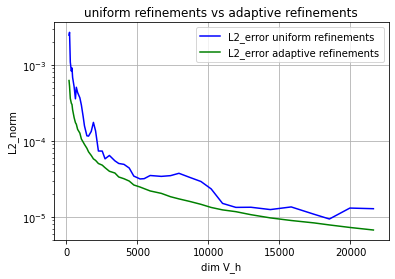

In [33]:
plt.figure()
plt.title("uniform refinements vs adaptive refinements")
plt.grid()
plt.semilogy(d_2,L2error_2,'b',label='L2_error uniform refinements')
plt.semilogy(d_2,H1error_2,'g',label='L2_error adaptive refinements')
#plt.semilogy(d_1,H1error_1)
#plt.semilogy(d_2,H1error_2)
plt.xlabel("dim V_h")
plt.ylabel("L2_norm")
plt.legend()
#plt.savefig('uniform refinements vs adaptive refinements')

### explenation
The blue line represents the error with the uniform refinments. That means the mesh is uniformt over the hole domain. The other line th error from the adaptive one. The algorytmus measures the error and define the new grid in the "critical area". It lies on the boundary on the circuit with an radius of $R$.

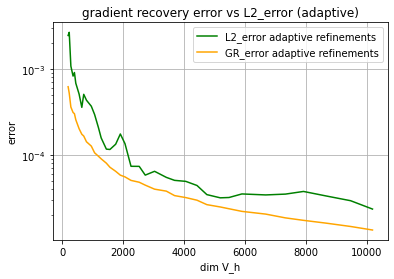

In [22]:
plt.figure()
plt.title("gradient recovery error vs L2_error (adaptive)")
plt.grid()
#plt.semilogy(d_1,L2error_1)
plt.semilogy(d_2,L2error_2,'g',label='L2_error adaptive refinements')
plt.semilogy(d_2,H1error_2,color='orange',label='GR_error adaptive refinements')
plt.xlabel("dim V_h")
plt.ylabel("error")
plt.legend()
#plt.savefig('gradient recovery error vs L2_error (adaptive)')

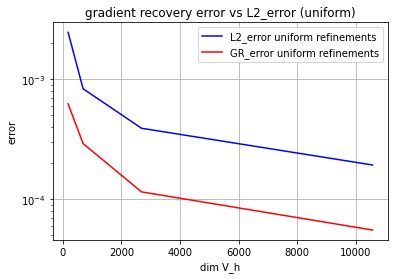

In [23]:
plt.figure()
plt.title("gradient recovery error vs L2_error (uniform)")
plt.grid()
#plt.semilogy(d_1,L2error_1)
plt.semilogy(d_1,L2error_1,'b',label='L2_error uniform refinements')
plt.semilogy(d_1,H1error_1,color='red',label='GR_error uniform refinements')
plt.xlabel("dim V_h")
plt.ylabel("error")
plt.legend()
#plt.savefig('gradient recovery error vs L2_error (uniform)')